In [1]:
!pip install matplotlib
!pip install pandas

In [2]:
import os
import numpy as np
import dill
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd


### 1 Compute the Linear Combination

In [3]:
file = 'sorted_pauli_list.pkl'
with open(file, 'rb') as f:
    sorted_pauli_list = dill.load(f)

coefficient_list = [coef for pauli_str, coef in sorted_pauli_list]


In [4]:
file = './aggregate_results/all_results.pkl'
with open(file, 'rb') as f:
    results = dill.load(f)

# Display the results
# print("Results:")
# for folder, folder_results in results.items():
#     print(f"\nFolder: {folder}")
#     for method, method_results in folder_results.items():
#         print(f"  {method}:")
#         for metric, value in method_results.items():
#             print(f"    {metric}: {value:.4f}")

In [5]:
# Initialize a dictionary to store the linear combination results for each method
linear_combinations = {}
err_bound = {}

methods = list(results['0'].keys())

# Initialize the linear combination to 0 for each method
for method in methods:
    linear_combinations[method] = 0
    err_bound[method] = 0

# Process each folder one by one
for i in range(len(results)):
    key = str(i)
    result = results[key]
    
    # Compute and update the linear combination for each method
    for method in methods:
        avg_center = result[method]['avg_interval_center']
        
        # Update the linear combination incrementally
        linear_combinations[method] += coefficient_list[i] * (2 * (1 - avg_center) - 1)
        err_bound[method] += abs(coefficient_list[i]) * result[method]['avg_interval_half_length']
    
    # Optional: print intermediate results if needed
    # print(f"After processing folder {i}, linear combinations so far:")
    # for method, result in linear_combinations.items():
    #     print(f"  {method}: {result:.6f}")

# Final display of the linear combination results with error bounds
print("\nFinal Linear Combination Results with Error Bounds:")
for method in linear_combinations:
    result = linear_combinations[method]
    error = err_bound[method]
    print(f"  {method}: {result:.6f} ± {error:.6f}")




Final Linear Combination Results with Error Bounds:
  Naive: -28.788418+0.000000j ± 0.004016
  IAE without Bayesian: -28.789666+0.000000j ± 0.002921
  IAE with Bayesian: -28.787370+0.000000j ± 0.004013
  Naive_fixed_shots: -28.649912+0.000000j ± 0.115694


### 2 Plots

In [6]:
x1 = range(len(results))
x2 = [results[str(x)]['Naive']['avg_interval_center'] for x in x1]
x2, x1 = zip(*sorted(zip(x2, x1)))

y_sc_naive = [results[str(x)]['Naive']['avg_sample_complexity'] for x in x1]
y_sc_iae = [results[str(x)]['IAE without Bayesian']['avg_sample_complexity'] for x in x1]
y_sc_bayes = [results[str(x)]['IAE with Bayesian']['avg_sample_complexity'] for x in x1]

y_dep_naive = [results[str(x)]['Naive']['avg_max_num_Q'] for x in x1]
y_dep_iae = [results[str(x)]['IAE without Bayesian']['avg_max_num_Q'] for x in x1]
y_dep_bayes = [results[str(x)]['IAE with Bayesian']['avg_max_num_Q'] for x in x1]

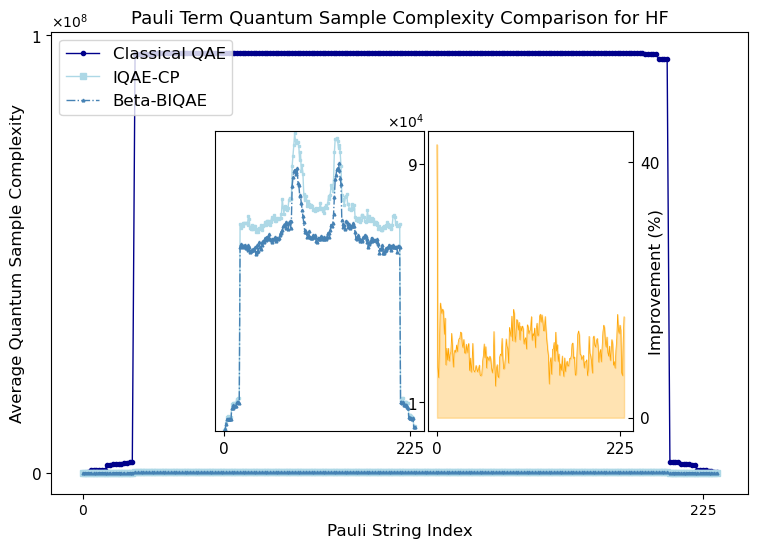

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create the main plot
fig, ax = plt.subplots(figsize=(9, 6))

# Plot the sample complexities for Naive, IAE without Bayesian, and IAE with Bayesian
ax.plot(range(len(x1)), y_sc_naive, label='Classical QAE', marker='o', color='#00008b', linewidth=1, markersize=3)
ax.plot(range(len(x1)), y_sc_iae, label='IQAE-CP', marker='s', color='#add8e6', linewidth=1, markersize=4)
ax.plot(range(len(x1)), y_sc_bayes, label='Beta-BIQAE', marker='^', color='#4682b4', linestyle='-.', linewidth=1, markersize=2)

# Reduce the number of x-axis ticks
step = 15
ax.set_xticks([0,225])
ax.set_xticklabels([0,225])
ax.set_yticks([0*10**6,1*10**8])
ax.set_yticklabels([0*10**6,1*10**8],fontsize=11)

# Enable scientific notation on the y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Add labels, title, and legend with smaller font size
ax.set_xlabel('Pauli String Index', fontsize=12)
ax.set_ylabel('Average Quantum Sample Complexity', fontsize=12)
ax.set_title('Pauli Term Quantum Sample Complexity Comparison for HF', fontsize=13)
ax.legend(loc='upper left', fontsize=12)

# Create the first zoomed-in inset
ax_inset1 = inset_axes(ax, width="100%", height="100%", loc="upper left",
                       bbox_to_anchor=(0.225, 0.15, 0.3, 0.65), bbox_transform=ax.transAxes)

ax_inset1.plot(range(len(x1)), y_sc_iae, label='IQAE-CP', marker='s', color='#add8e6', linewidth=1, markersize=2)
ax_inset1.plot(range(len(x1)), y_sc_bayes, label='Beta-BIQAE', marker='^', color='#4682b4', linestyle='-.', linewidth=1, markersize=2)

# Reduce x-axis labels for the inset
ax_inset1.set_xticks([0,225])
ax_inset1.set_xticklabels([0,225], fontsize=11)
ax_inset1.set_yticks([1*10**4,9*10**4])
ax_inset1.set_yticklabels([1*10**4,9*10**4], fontsize=11)

ax_inset1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_inset1.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_inset1.yaxis.tick_right()
ax_inset1.tick_params(axis='y', direction='in', pad=-12, labelsize=11)
ax_inset1.set_ylim(min(y_sc_bayes) - 100, max(y_sc_iae) + 600)

# Create the second zoomed-in inset
ax_inset2 = inset_axes(ax, width="100%", height="100%", loc="upper right",
                       bbox_to_anchor=(0.55, 0.15, 0.295, 0.65), bbox_transform=ax.transAxes)

# Calculate improvement percentages and plot a line
improvement_percentages = [(iae - bayes) / iae * 100 for iae, bayes in zip(y_sc_iae, y_sc_bayes)]
ax_inset2.plot(range(len(x1)), improvement_percentages, color='orange', linewidth=0.5)

# Fill the area below the line
ax_inset2.fill_between(range(len(x1)), improvement_percentages, color='orange', alpha=0.3)

# Reduce x-axis labels for the line plot
ax_inset2.set_xticks([0,225])
ax_inset2.set_xticklabels([0,225], fontsize=11)
ax_inset2.set_yticks([0,40])
ax_inset2.set_yticklabels([0,40], fontsize=11)

# Set integer y-axis ticks for the line plot
ax_inset2.yaxis.set_label_position("right")  # 将 y 轴标签移动到右侧
# ax_inset2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax_inset2.yaxis.tick_right()
ax_inset2.tick_params(axis='y', direction='in', pad=5, labelsize=11)
# ax_inset2.set_ylim(min(improvement_percentages) - 1, max(improvement_percentages) + 2)

ax_inset2.set_ylabel('Improvement (%)', fontsize=12, labelpad=-8)

# save and how
plt.savefig('sc.png', format='png', dpi=300)
plt.show()


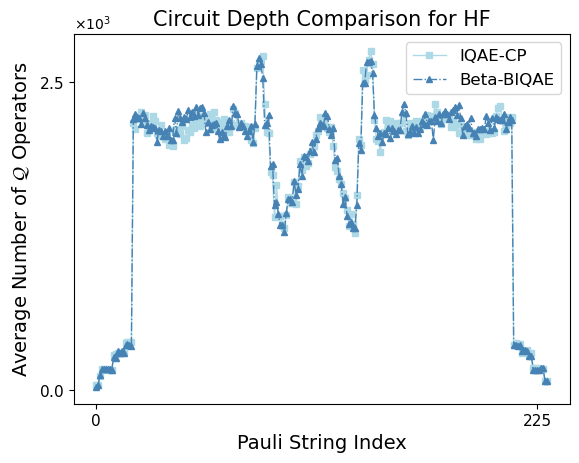

In [8]:
# Plot the depths for IQAE and Bayesian IQAE
plt.plot(range(len(x1)), y_dep_iae, label='IQAE-CP', marker='s', color='#add8e6', linewidth=1, markersize=4)
plt.plot(range(len(x1)), y_dep_bayes, label='Beta-BIQAE', marker='^', color='#4682b4', linestyle='-.', linewidth=1, markersize=4)

# Set x-axis ticks and labels based on x1
step = 15   # Reduce the number of x-axis ticks
plt.xticks(ticks=[0,225], labels=[0,225], fontsize=11)
plt.yticks(ticks=[0*10**3,2.5*10**3], labels=[0,2.5*10**3], fontsize=11)

# Enable scientific notation on the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Add labels, title, and legend
plt.xlabel('Pauli String Index',fontsize=14)
plt.ylabel(r"Average Number of $\mathcal{Q}$ Operators",fontsize=14)
plt.title('Circuit Depth Comparison for HF',fontsize=15)
plt.legend(fontsize=12)

plt.savefig('dep.png', format='png', dpi=300)  # dpi=300 for high quality

# Show the plot
plt.show()

### 3 Summary

In [9]:
# Final display of the linear combination results with error bounds
print("\nFinal Linear Combination Results with Error Bounds:")
for method in linear_combinations:
    result = linear_combinations[method]
    error = err_bound[method]
    print(f"  {method}: {result.real:.6f} ± {error:.6f}")


Final Linear Combination Results with Error Bounds:
  Naive: -28.788418 ± 0.004016
  IAE without Bayesian: -28.789666 ± 0.002921
  IAE with Bayesian: -28.787370 ± 0.004013
  Naive_fixed_shots: -28.649912 ± 0.115694


In [10]:
print("Total Quantum Sample Complexity Resutls:")
print(f"Classical QAE: {sum(y_sc_naive):.0f}")
print(f"IAE without Bayesian: {sum(y_sc_iae):.0f}")
print(f"IAE with Bayesian: {sum(y_sc_bayes):.0f}")

Total Quantum Sample Complexity Resutls:
Classical QAE: 18671779450
IAE without Bayesian: 14883592
IAE with Bayesian: 13279369


In [11]:
# Define the storage directory and file path
output_dir = "../plot"
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, "summary.csv")

# Create a data structure to store the results
data = {}
methods = list(linear_combinations.keys())

# Store the results of each method in the corresponding column
for method in methods:
    data[f"{method} (est)"] = [linear_combinations[method].real]
    data[f"{method} (err_bound)"] = [err_bound[method]]

# Store the total results in the corresponding columns
data["Naive (total_sc)"] = [sum(y_sc_naive)]
data["IAE without Bayesian (total_sc)"] = [sum(y_sc_iae)]
data["IAE with Bayesian (total_sc)"] = [sum(y_sc_bayes)]

# Create a DataFrame
df = pd.DataFrame(data)

# If the file already exists, append a new row
if os.path.exists(file_path):
    existing_df = pd.read_csv(file_path)
    combined_df = pd.concat([existing_df, df], ignore_index=True)
else:
    combined_df = df

# Save the results to a CSV file
combined_df.to_csv(file_path, index=False)